In [30]:
import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Collaborative-based Filtering.

Collaborative Filtering is a reccomendation system based on the fact relationships exists between products and people's interests.

Collaborative filtering has two approaches:

1. User-based
2. Item-based

**User-based**

User-based is based on the user's similarity or neighbourhood.

**Item-based**
Item-based is based on similaririty amongst items.

In the cells below we use the collaborative filtering algorithm to build a recommendation system for a movie datasest based on user's rating.
We will use both the ratings and movies datasets to achieve this task.


#### 1.  Exploring ratings data

In [33]:
ratings = pd.read_csv("train.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [34]:
ratings.shape

(10000038, 4)

As can seen above the ratings dataset consists of 4 features and 10000038 entries.
Based on this information, it can be deduced that this is large dataset.

Below we will check the number of users that have given ratings

In [36]:
ratings.userId.value_counts()

72315     12952
80974      3680
137293     3588
33844      3208
20055      3050
          ...  
127098        1
121071        1
55362         1
105714        1
79087         1
Name: userId, Length: 162541, dtype: int64

As can be noted about 162541 users have given a rating.

array([[<AxesSubplot:title={'center':'rating'}>]], dtype=object)

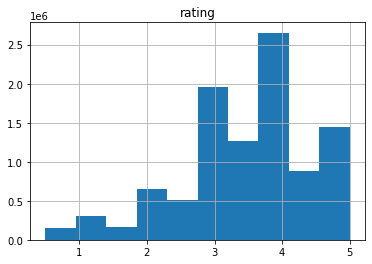

In [37]:
ratings.hist(column='rating')

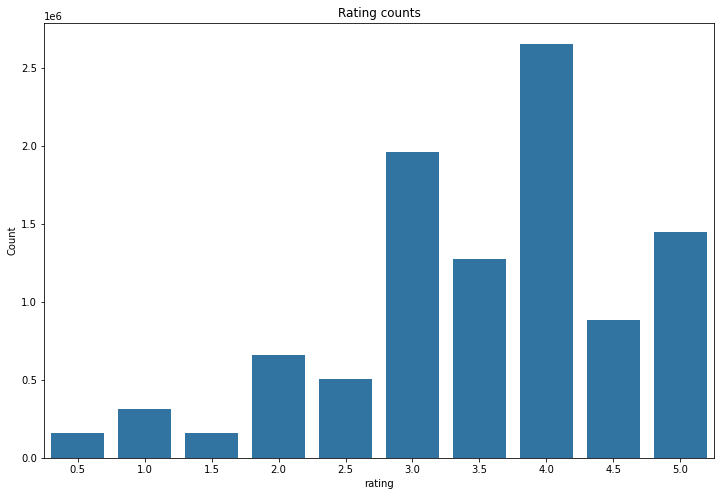

In [38]:
plt.figure(figsize=(12,8)) #set fig size
base_color = sns.color_palette()[0]
sns.countplot(x='rating' ,data = ratings,color=base_color)
plt.ylabel('Count')
plt.xlabel('rating')
plt.title('Rating counts')
plt.show()

We extract users who have given more than 250 ratings

In [39]:
x = ratings['userId'].value_counts() > 250
y = x[x].index  #user_ids
print(y.shape)
ratings = ratings[ratings['userId'].isin(y)]

(6548,)


In [40]:
movies = pd.read_csv("movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Merge Datasets

In [42]:
rating_with_movies = ratings.merge(movies, on='movieId')
rating_with_movies.head()

,userId,movieId,rating,timestamp,title,genres
0,106362,32296,2.0,1423042565,Miss Congeniality 2: Armed and Fabulous (2005),Adventure|Comedy|Crime
1,55462,32296,3.0,1122292610,Miss Congeniality 2: Armed and Fabulous (2005),Adventure|Comedy|Crime
2,42894,32296,0.5,1301377531,Miss Congeniality 2: Armed and Fabulous (2005),Adventure|Comedy|Crime
3,132358,32296,1.5,1536262889,Miss Congeniality 2: Armed and Fabulous (2005),Adventure|Comedy|Crime
4,3545,32296,1.5,1173948188,Miss Congeniality 2: Armed and Fabulous (2005),Adventure|Comedy|Crime


### Drop uneeded columns

In [43]:
rating_with_movies.drop(['timestamp', 'genres'], axis=1, inplace=True)

In [44]:
rating_with_movies.head()

,userId,movieId,rating,title
0,106362,32296,2.0,Miss Congeniality 2: Armed and Fabulous (2005)
1,55462,32296,3.0,Miss Congeniality 2: Armed and Fabulous (2005)
2,42894,32296,0.5,Miss Congeniality 2: Armed and Fabulous (2005)
3,132358,32296,1.5,Miss Congeniality 2: Armed and Fabulous (2005)
4,3545,32296,1.5,Miss Congeniality 2: Armed and Fabulous (2005)


### Extrat Books that have received mre than 50 ratings

In [48]:
number_rating = rating_with_movies.groupby('title')['rating'].count().reset_index()
number_rating.rename(columns= {'rating':'number_of_ratings'}, inplace=True)
final_rating = rating_with_books.merge(number_rating, on='title')

final_rating = final_rating[final_rating['number_of_ratings'] >= 50]
final_rating.drop_duplicates(['userId','title'], inplace=True)

In [49]:
final_rating.shape

(2635436, 7)

### Pivot Table

In [50]:
book_pivot = final_rating.pivot_table(columns='userId', index='title', values="rating")
book_pivot.fillna(0, inplace=True)

In [51]:
book_pivot.shape

(7785, 6548)

In [52]:
import numpy as np
import scipy as sp

In [53]:
# Normalize each row (a given user's ratings) of the utility matrix
util_matrix_norm = book_pivot.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)), axis=1)
# Fill Nan values with 0's, transpose matrix, and drop users with no ratings
util_matrix_norm.fillna(0, inplace=True)
util_matrix_norm = util_matrix_norm.T
util_matrix_norm = util_matrix_norm.loc[:, (util_matrix_norm != 0).any(axis=0)]
# Save the utility matrix in scipy's sparse matrix format
util_matrix_sparse = sp.sparse.csr_matrix(util_matrix_norm.values)

In [54]:
util_matrix_sparse.shape

(6548, 7785)

### Modelling

In [55]:
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.feature_extraction.text import TfidfVectorizer

# Libraries used during sorting procedures.
import operator # <-- Convienient item retrieval during iteration 
import heapq # <-- Efficient sorting of large lists
from scipy.sparse import csr_matrix
book_sparse = csr_matrix(book_pivot)
from sklearn.neighbors import NearestNeighbors

# Imported for our sanity
import warnings
warnings.filterwarnings('ignore')

In [57]:

model = NearestNeighbors(algorithm='brute')
model.fit(book_sparse)

NearestNeighbors(algorithm='brute')

### Predictions

In [58]:
distances, suggestions = model.kneighbors(book_pivot.iloc[2, :].values.reshape(1, -1))

In [59]:
for i in range(len(suggestions)):
  print(book_pivot.index[suggestions[i]])

Index([''burbs, The (1989)', 'Leonard Part 6 (1987)', 'King Kong Lives (1986)',
       'Ernest Goes to Africa (1997)', 'Shanghai Surprise (1986)'],
      dtype='object', name='title')
